In [1]:
# !pip install monai==1.1.0
# import monai

In [2]:
# !pip install wandb==0.9.4

In [3]:
# import wandb
# wandb.__version__

In [4]:
import os
gpus= "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpus
# os.environ["WANDB_API_KEY"] = '6cd6a2f58c8f4625faaea5c73fe110edab2be208'

import monai
monai.__version__

'1.1.0'

In [42]:
from data import * 
import torch
import models
from models.unet import *
from models.densenet import *
from models.resnet import *
from models.efficientnet import *
from models.ffc import *
import monai
import scipy.ndimage

def find_cluster_midpoints(arr):
    clusters = []
    cluster_start = None

    for i in range(len(arr)):
        if arr[i] == 1:
            if cluster_start is None:
                cluster_start = i
        else:
            if cluster_start is not None:
                cluster_end = i - 1
                midpoint_idx = (cluster_start + cluster_end) // 2
                clusters.append(midpoint_idx)
                cluster_start = None

    # 마지막 클러스터가 배열의 끝까지 이어지는 경우 처리
    if cluster_start is not None:
        midpoint_idx = (cluster_start + len(arr) - 1) // 2
        clusters.append(midpoint_idx)

    return clusters

def plot_attentionMap(x_,y_seg_,yhat_,suptitle):
    
    # get nonPVC idx from GT
    idx_nonPVC_GT = find_cluster_midpoints(y_seg_[0,0])
    idx_nonPVC_PRED = find_cluster_midpoints(yhat_[0,0].round())

    # get PVC idx from y_seg_ or yhat_
    idx_PVC_GT = find_cluster_midpoints(y_seg_[0,1])
    idx_PVC_PRED = find_cluster_midpoints(yhat_[0,1].round())
    
    upper_limit = 6
    lower_limit = -6
    
    plt.subplot(141)
    plt.title('Ground truth')
    plt.plot(x_[0,0],color='black')
    plt.plot(y_seg_[0,1],color='b')
    plt.ylim((lower_limit,upper_limit))
    plt.scatter(idx_nonPVC_GT,[lower_limit+.2]*len(idx_nonPVC_GT),color='green')
    plt.scatter(idx_PVC_GT,[lower_limit+.2]*len(idx_PVC_GT),color='red')
    plt.axis('off')
    
    plt.text(-200, .8, "PVC\nGround truth", ha='center', wrap=True, color='blue')
    plt.text(-200, lower_limit+.15, "PVC", ha='center', wrap=True, color='red')
    plt.text(-200, lower_limit-.15, "non-PVC", ha='center', wrap=True, color='green')

    plt.subplot(142)
    plt.title('Prediction')
    plt.plot(x_[0,0],color='black')
    plt.plot(yhat_[0,1],color='b')
    plt.ylim((lower_limit,upper_limit))
    plt.scatter(idx_nonPVC_PRED,[lower_limit+.2]*len(idx_nonPVC_PRED),color='green')
    plt.scatter(idx_PVC_PRED,[lower_limit+.2]*len(idx_PVC_PRED),color='red')
    plt.axis('off')

    plt.text(-200, .8, "PVC\nLikelihood", ha='center', wrap=True, color='blue')

    plt.subplot(143)
    plt.title('K Map')
    plt.plot(x_[0,0],color='black')
    plt.ylim((lower_limit,upper_limit))
    plt.scatter(idx_nonPVC_GT,[lower_limit+.2]*len(idx_nonPVC_GT),color='green')
    plt.scatter(idx_PVC_GT,[lower_limit+.2]*len(idx_PVC_GT),color='red')
    plt.axis('off')

    plt.text(640, upper_limit-.4, "Darker color represents higher values", ha='center', wrap=True, color='red',backgroundcolor='white')

    plt.subplot(144)
    plt.title('Q Map')
    plt.plot(x_[0,0],color='black')
    plt.ylim((lower_limit,upper_limit))
    plt.scatter(idx_nonPVC_PRED,[lower_limit+.2]*len(idx_nonPVC_PRED),color='green')
    plt.scatter(idx_PVC_PRED,[lower_limit+.2]*len(idx_PVC_PRED),color='red')
    plt.axis('off')

    plt.text(640, upper_limit-.4, "Darker color represents higher values", ha='center', wrap=True, color='green', backgroundcolor='white')

    plt.suptitle(suptitle, fontsize = 20)


In [6]:
config_defaults = dict(
    dataNorm ='zscoreO', # zscoreI, zscoreO, minmaxI
    modelName='basic', # 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'resnet34', 'densenet169', 'U2NET','U2NETP', 'basis'
    encModule = "SCM12", # "SE_BOTTOM5"
    decModule = "NONE", # "SE_BOTTOM5"
    segheadModule = "NONE",
    
    project = 'PVC-NET',  ########################## this is cutoff line of path_logRoot ##############################

    dataSeed = 1, # split seed
    srTarget = 250, # 
    featureLength = 1280,
    sampler = True, # True, False
    inChannels = 1,
    outChannels = 2,

    norm = 'instance', # 'instance', 'batch', 'group', 'layer'
    upsample = 'deconv', #'pixelshuffle', # 'nontrainable', 'deconv'
    supervision = "NONE", #'NONE', 'TYPE1', 'TYPE2'
    dropout = 0.1,
    mtl = 'NONE', # 'NONE', 'CLS, 'REC', 'ALL_avg', 'ALL_max'
    trainaug = 'NEUROKIT2',

    path_logRoot = 'exp_20230410',
    spatial_dims = 1,
    learning_rate = 1e-3,
    batch_size = 512, # 256
    thresholdRPeak = 0.7,
    lossFn = 'BCE',
)

from main import *

path = 'weight/exp_20230830_DCAM/dataNormzscoreO_modelNamebasic_encModuleTFCAM8_1_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'
# path = 'weight/encModuleTFCAM32_12_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'
net = PVC_NET(config_defaults).load_from_checkpoint(path, strict=True)
net.eval()

path = 'weight/encModuleTFCAM32_12_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'
net_DCAM = PVC_NET(config_defaults).load_from_checkpoint(path, strict=True)
net_DCAM.eval()

saving path : exp_20230830_DCAM/dataNormzscoreO_modelNamebasic_encModuleTFCAM8_1_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64, 128, 256, 512, 512]
U-NET encModule is TFCAM8_1
U-NET mtl is NONE
U-NET decModule is NONE
U-NET supervision is NONE
U-NET segheadModule is NONE
saving path : exp_20230830_DCAM/dataNormzscoreO_modelNamebasic_encModuleTFCAM8_1_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64, 128, 256, 512, 512]
U-NET encModule is TFCAM8_1
U-NET mtl is NONE
U-NET decModule is NONE
U-NET supervision is NONE
U-NET segheadModule is NONE
saving path : exp_20230830_DCAM/dataNormzscoreO_modelNamebasic_encModuleTFCAM8_1_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64, 128, 256, 512, 512]
U-NET encModule is TFCAM8_1
U-NET mtl is NONE
U-NET decModule is NONE
U-NET supervision is NONE
U-NET segheadModule is NONE
saving path : exp_20230421_TFCAM12/encModuleTFCAM32_12_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64,

PVC_NET(
  (net): UNet(
    (conv_0): TwoConv(
      (conv_0): Convolution(
        (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (adn): ADN(
          (N): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.1, inplace=False)
          (A): GELU()
        )
      )
      (conv_1): Convolution(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (adn): ADN(
          (N): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.1, inplace=False)
          (A): GELU()
        )
      )
    )
    (down_1): Down(
      (max_pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Convolution(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (adn): ADN(
            (N): InstanceNorm1d(64, eps=1e-05, momentum=0

In [7]:
# net.net.down_1.att.add_mod.return_weight = True
# net.net.down_2.att.add_mod.return_weight = True
# net.net.down_3.att.add_mod.return_weight = True
net.net.down_4.att.add_mod.return_weight = True
# net.net.down_5.att.add_mod.return_weight = True

# net_DCAM.net.down_3.att.add_mod.return_weight = True
net_DCAM.net.down_4.att.add_mod.return_weight = True

In [8]:
featureLength = 1280
srTarget = 250
classes = 2
dataNorm = 'zscoreO'
batch_size = 8

test_dataset = MIT_DATASET(test_data, featureLength, srTarget, classes, dataNorm, False)
# test_dataset = MIT_DATASET(INCART_data,featureLength, srTarget, classes, dataNorm, False)
# test_dataset = MIT_DATASET(NS_data,featureLength, srTarget, classes, dataNorm, False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers=1, pin_memory=True)

iterator = iter(test_loader)

In [9]:
batch = next(iterator)
x = batch['signal']
y_seg = batch['y_seg']
y_PVC_seg = batch['y_PVC_seg']
y = batch['y_PVC']
x.shape, y

(torch.Size([8, 1, 5000]),
 tensor([[0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [0]]))

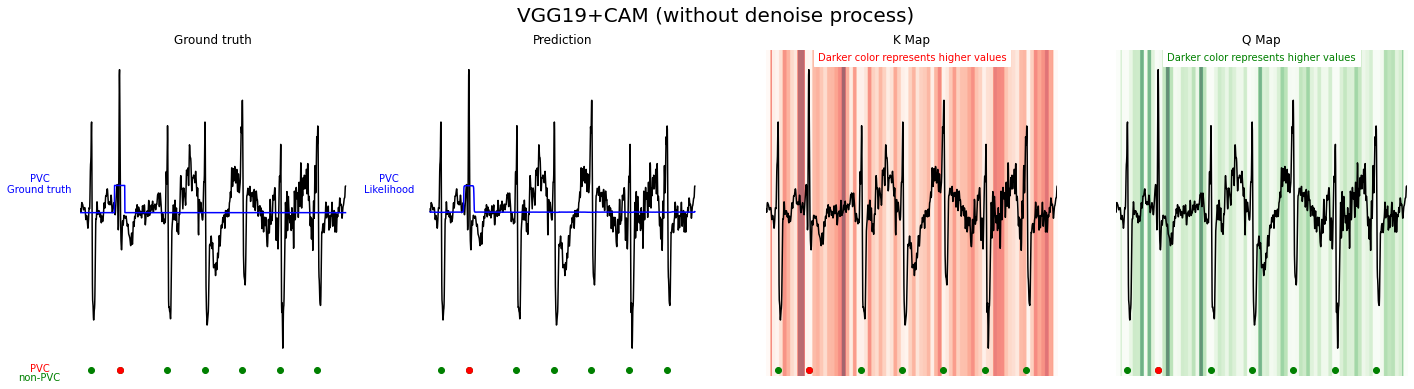

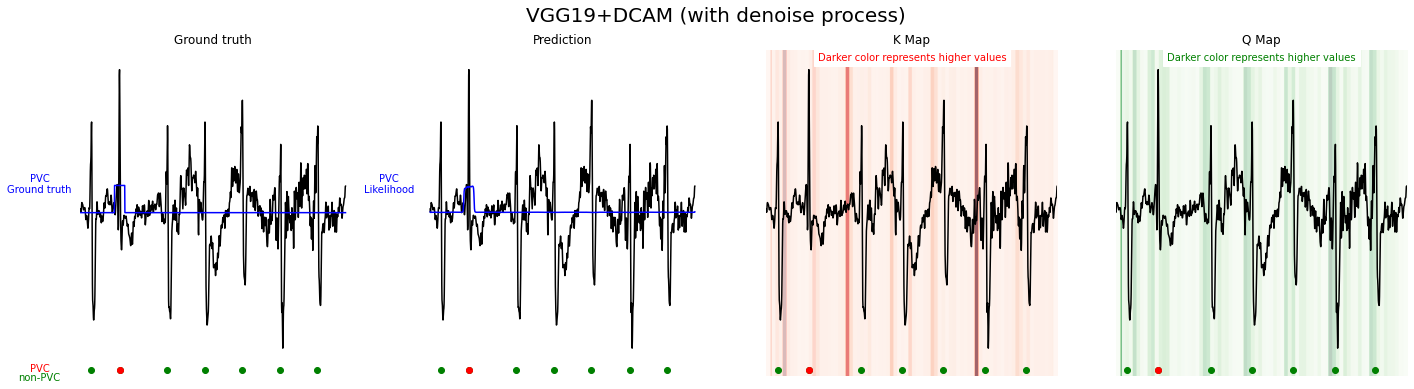

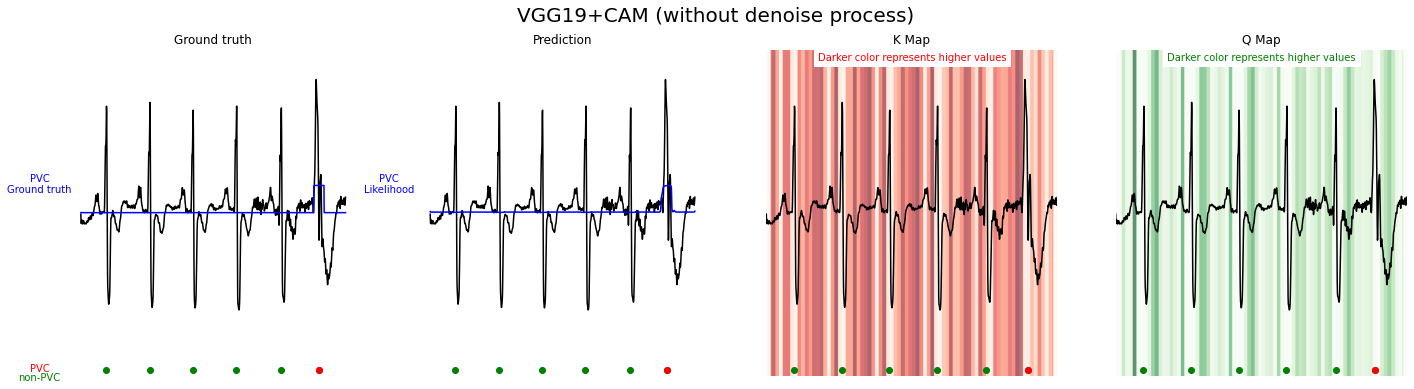

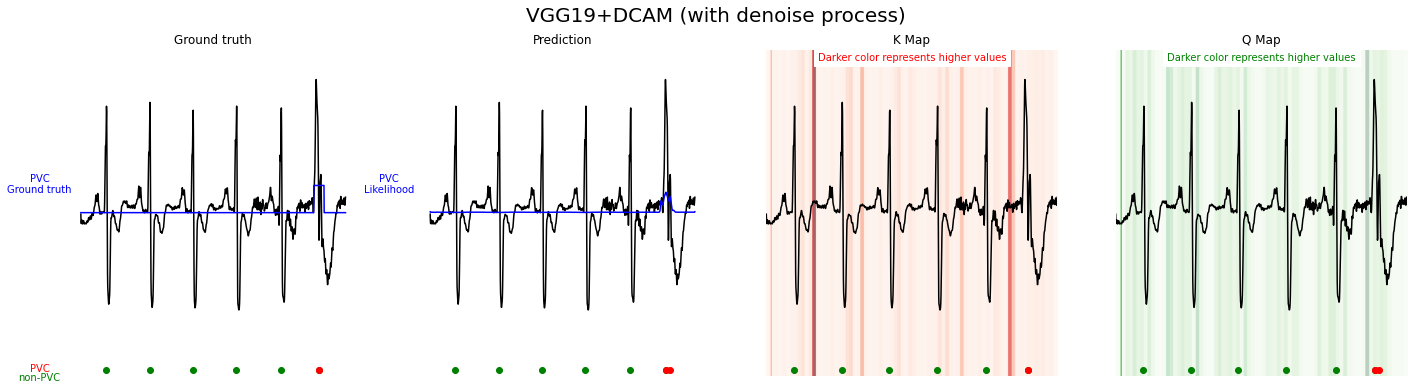

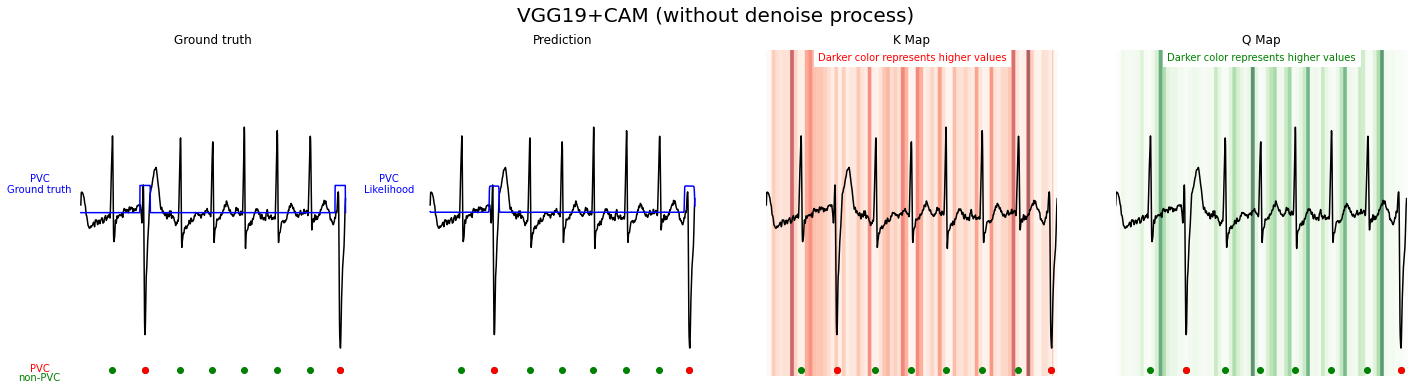

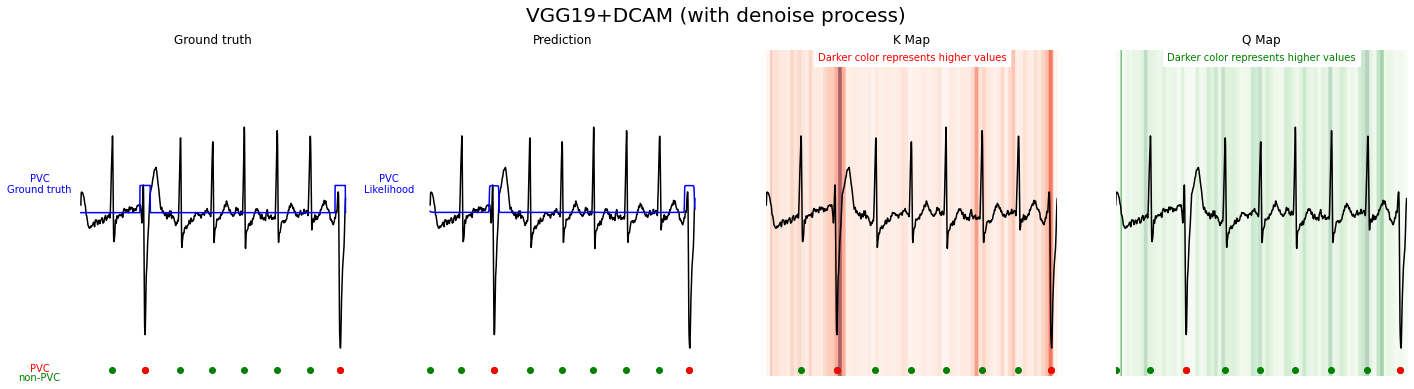

In [43]:
for idx in range(x.shape[0]):

    start = 0
    end = start + 1280
    x_ = x[idx:idx+1,:,start:end]
    y_seg_ = y_seg[idx:idx+1,:,start:end]
    
    if 1 in y_seg_[0,1]: 

        plt.figure(figsize=(24,6))
        yhat = net(x_)
        yhat_ = yhat[:,:,start:end].detach().numpy()
        plot_attentionMap(x_,y_seg_,yhat_, 'VGG19+CAM (without denoise process)')
        plt.show()

        plt.figure(figsize=(24,6))
        yhat_DCAM = net_DCAM(x_)
        yhat_DCAM_ = yhat_DCAM[:,:,start:end].detach().numpy()
        plot_attentionMap(x_,y_seg_,yhat_DCAM_, 'VGG19+DCAM (with denoise process)')
        plt.show()
        print()